### Практическое задание
1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в
комментариях к уроку, какого результата вы добились от нейросети, что помогло
улучшить её точность?
2. *Попробуйте свои силы в задаче Carvana на Kaggle:
https://www.kaggle.com/c/carvana-image-masking-challenge/overview
3. *Сделайте свою реализацию U-Net на TensorFlow

https://github.com/bearpaw/clothing-co-parsing

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

C:\Users\odind\anaconda3\envs\learning_tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Проверить GPU

### функции для визуализации

In [2]:
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        pred_mask = model.predict(sample_image[tf.newaxis, ...])
        display([sample_image, sample_mask, create_mask(pred_mask)])

In [3]:
DATASET_PATH = 'clothing-co-parsing/photos/'
MASKS_PATH = 'clothing-co-parsing/annotations/pixel-level/'

In [4]:
def preprocess_image(image):
    image = tf.cast(image, tf.float32)
    # scale values to [0,1]
    image = image / 255.0
    # resize image
    image = tf.image.resize(image, (128, 128))
    return image

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128, 128))
#     # для бинарной классификации (фон и человек):
#     mask = tf.cast(mask != 0, tf.uint8)
    return mask

In [5]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
    image_filename = mask_filename[:-4] + '.jpg'
    image = img_to_array(load_img(DATASET_PATH + image_filename))
    images.append(preprocess_image(image))
    
    mask_file = io.loadmat(MASKS_PATH + mask_filename)
    mask = tf.convert_to_tensor(mask_file['groundtruth'])
    masks.append(preprocess_mask(mask))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    images, 
    masks, 
    test_size=0.2, 
    random_state=42
)
sample_image, sample_mask = X_train[0], y_train[0]

X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

train = tf.data.Dataset.zip((X_train, y_train))
test = tf.data.Dataset.zip((X_test, y_test))

In [7]:
# functions for augmentation

# яркость 
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# оттенок 
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# зеркало по горизонтали 
def flip_horizontal(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

In [8]:
# augmentation
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horizontal))

In [9]:
len(train)

6424

In [10]:
BATCH_SIZE = 32
BUFFER_SIZE = 500

train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE)

In [11]:
sample_image.shape

TensorShape([128, 128, 3])

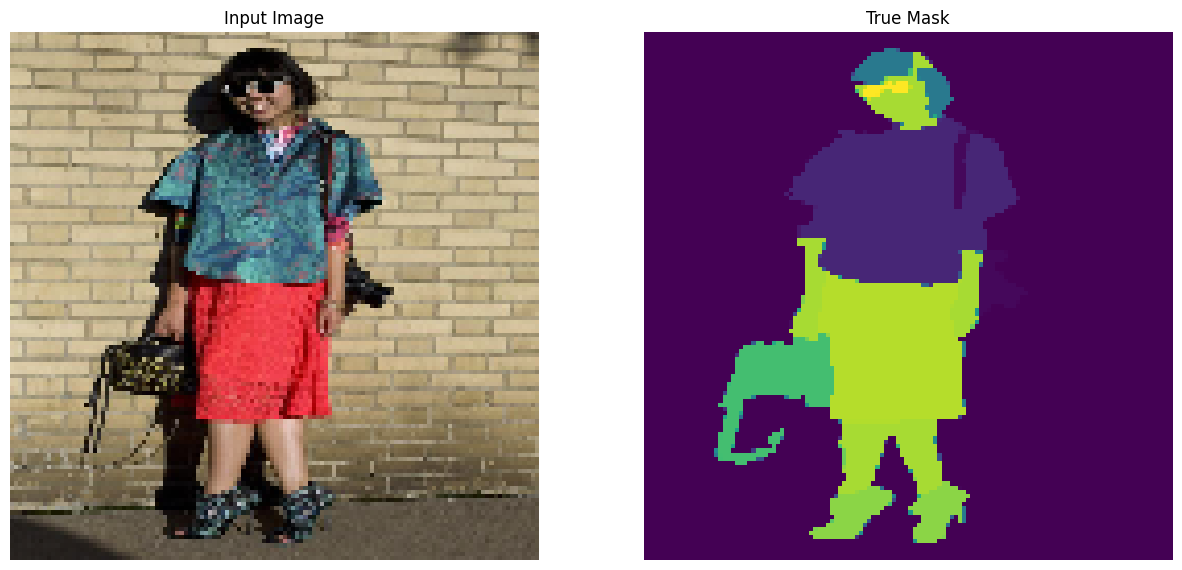

In [12]:
display([sample_image, sample_mask])

In [13]:
tf.unique(tf.reshape(sample_mask, -1))

Unique(y=<tf.Tensor: shape=(161,), dtype=float32, numpy=
array([0.00000000e+00, 1.81917114e+01, 1.90000000e+01, 1.29140625e+01,
       1.86277466e+01, 4.10000000e+01, 3.10052490e+00, 6.72656250e+00,
       2.16857910e-01, 4.72210693e+00, 3.32656250e+01, 9.35156250e+00,
       1.76640625e+01, 3.80781250e+01, 2.05468750e+01, 1.37780151e+01,
       3.45312500e+01, 4.43281250e+01, 4.70000000e+01, 4.25340576e+01,
       4.34415283e+01, 4.32613525e+01, 3.23515625e+01, 4.52088623e+01,
       4.06796875e+01, 4.69871826e+01, 2.27530518e+01, 3.27227173e+01,
       4.40468750e+01, 2.06636963e+01, 2.84531250e+01, 7.97271729e+00,
       3.52343750e+00, 6.20312500e+00, 5.00000000e+00, 4.57031250e+00,
       2.05280762e+01, 3.94531250e+00, 9.21875000e+00, 1.83593750e+00,
       3.53125000e+00, 1.49438477e+00, 1.40625000e+00, 1.10443115e+00,
       1.00000000e+00, 3.32641602e-02, 3.05450439e+00, 4.21875000e+00,
       4.81048584e+00, 7.15637207e-01, 8.58459473e-01, 3.03125000e+00,
       1.13281250e+0

### Модель

In [14]:
tf.random.set_seed(42)

### Encoder (слои из предобученной модели MobileNetV2)

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
base_model

In [16]:
# use the activations of these layers
layer_names = [
    'block_1_expand_relu', # 64x64
    'block_3_expand_relu', # 32x32
    'block_6_expand_relu', # 16x16
    'block_13_expand_relu', # 8x8
    
    # Убрал слой, так как он не может хранить 59 ответов в 16 клетках (это моя эмпирическая догадка)
    
#     'block_16_project', # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

### Decoder

In [17]:
up_stack = [
    
    # больше мелочей - больше признаков (прибавил карточек, относительно разобранного на уроке варианта)
    
    tf.keras.layers.Conv2DTranspose(2048, 3, strides=2, padding='same',
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(1024, 3, strides=2, padding='same',
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same',
                                    use_bias=False, activation='relu'),
    
    # зеркально и здесь убрал естественно
    
#     tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same',
#                                     use_bias=False, activation='relu'),
    
]

def resolution_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs
    
    # downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        
        # добавил дропаутов, а то переобучалась слишком
        x = tf.keras.layers.Dropout(0.4)(x)
        
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    
    # this is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, padding='same'
    )  # 64x64 -> 128x128
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
OUTPUT_CHANNELS = 59

model = resolution_model(OUTPUT_CHANNELS)

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


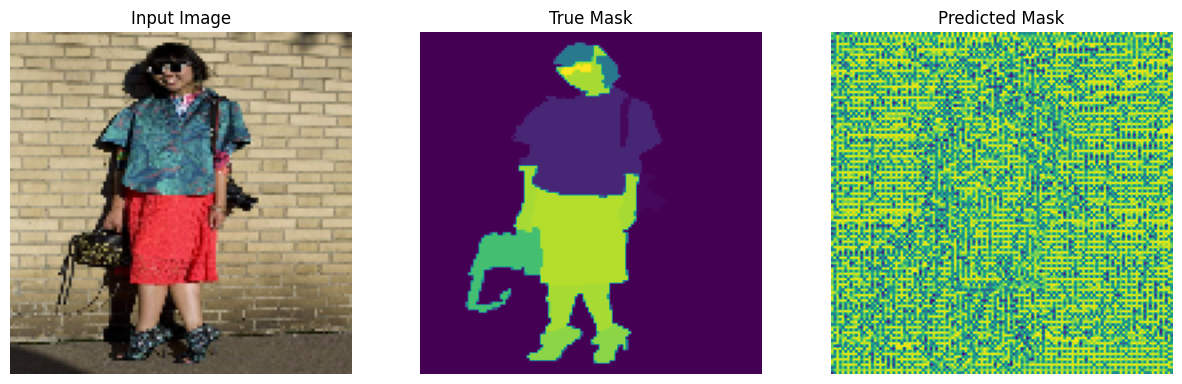

In [21]:
show_predictions(model)

### Train

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(model)
        print(f'\nSample prediction after epoch {epoch + 1}\n')

In [23]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta=0.0005, patience=3, restore_best_weights=True)

Epoch 1/10000
201/201 [==============================] - 99s 385ms/step - loss: 0.8721 - accuracy: 0.7877 - val_loss: 0.6268 - val_accuracy: 0.8334


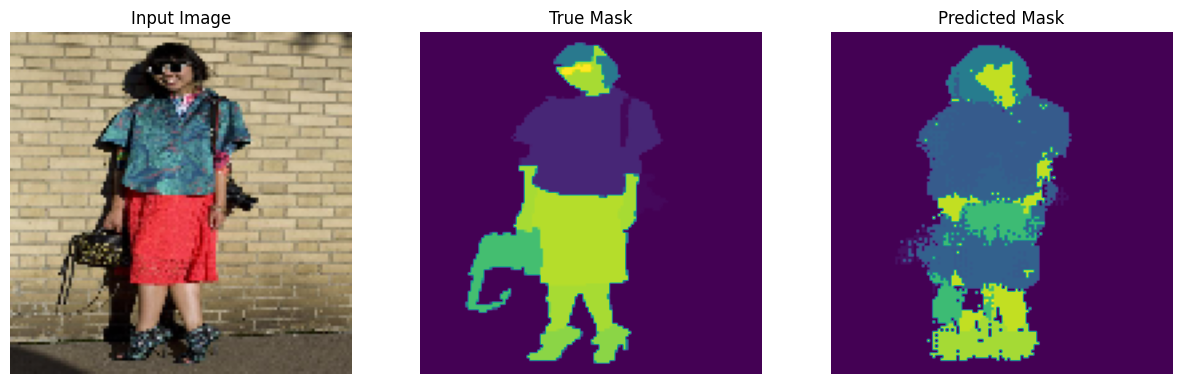


Sample prediction after epoch 1

Epoch 2/10000
201/201 [==============================] - 60s 298ms/step - loss: 0.5892 - accuracy: 0.8405 - val_loss: 0.5591 - val_accuracy: 0.8468


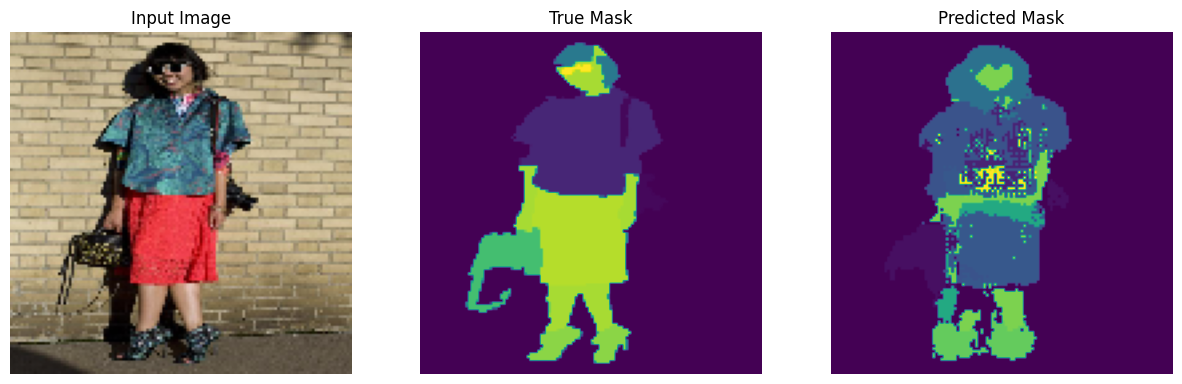


Sample prediction after epoch 2

Epoch 3/10000
201/201 [==============================] - 60s 298ms/step - loss: 0.5159 - accuracy: 0.8578 - val_loss: 0.5503 - val_accuracy: 0.8497


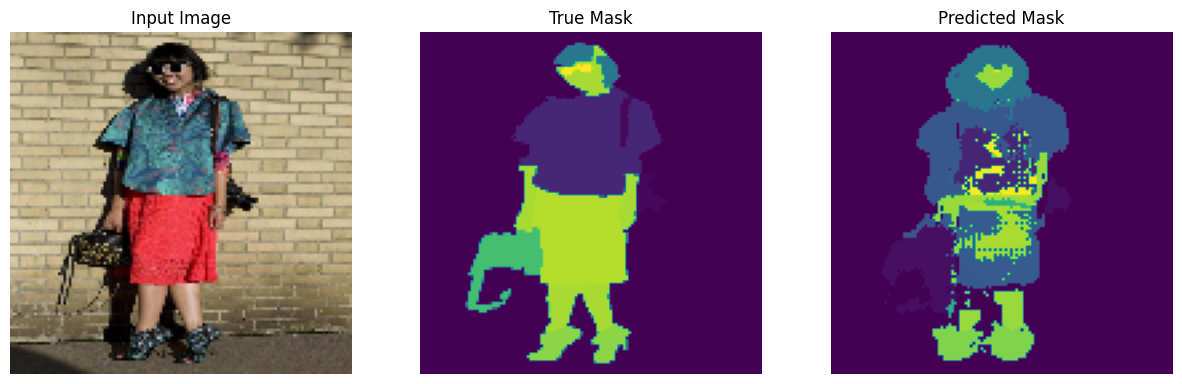


Sample prediction after epoch 3

Epoch 4/10000
201/201 [==============================] - 60s 298ms/step - loss: 0.4584 - accuracy: 0.8732 - val_loss: 0.5450 - val_accuracy: 0.8528


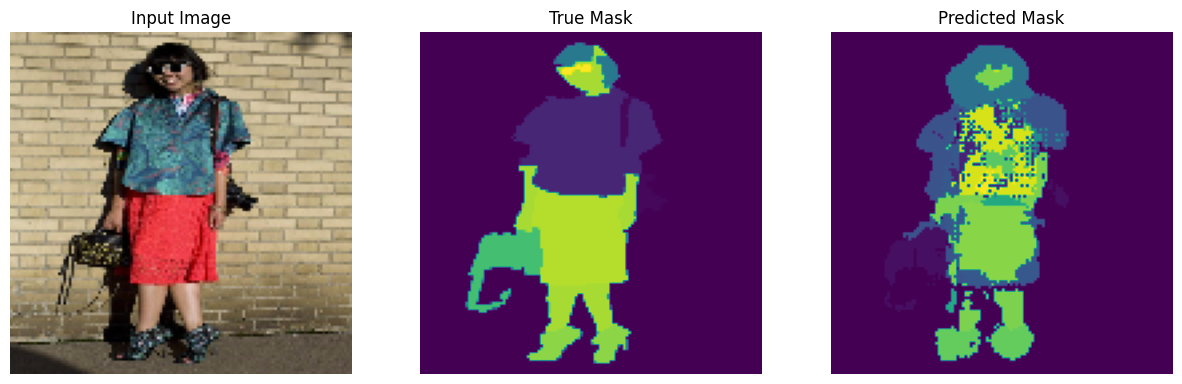


Sample prediction after epoch 4

Epoch 5/10000
201/201 [==============================] - 60s 297ms/step - loss: 0.4076 - accuracy: 0.8877 - val_loss: 0.5740 - val_accuracy: 0.8545


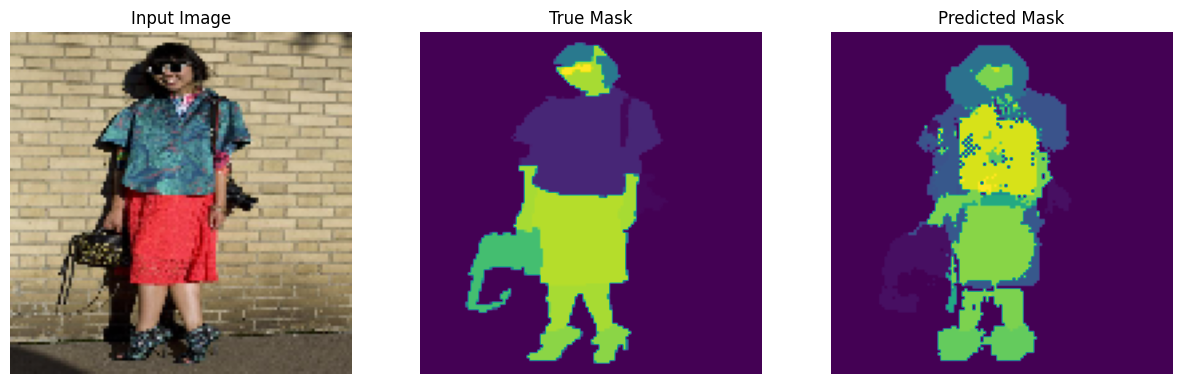


Sample prediction after epoch 5

Epoch 6/10000
201/201 [==============================] - 60s 298ms/step - loss: 0.3609 - accuracy: 0.9010 - val_loss: 0.5924 - val_accuracy: 0.8544


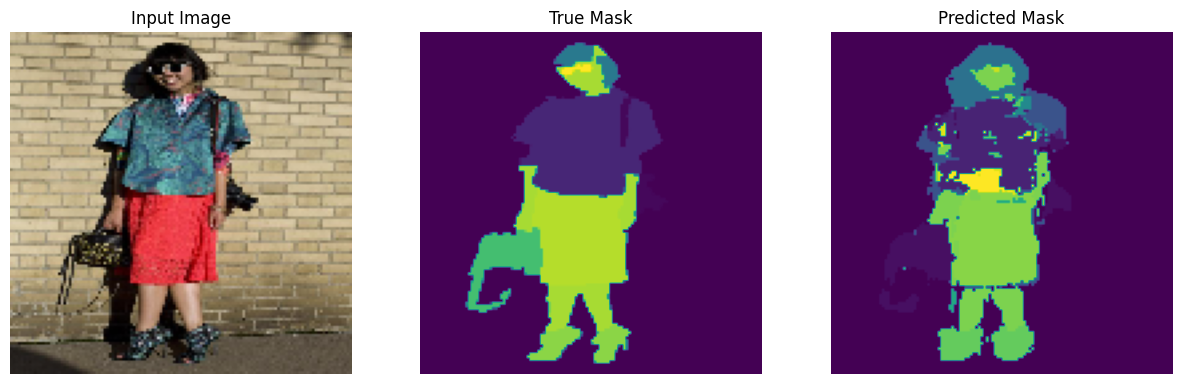


Sample prediction after epoch 6

Epoch 7/10000
201/201 [==============================] - 60s 297ms/step - loss: 0.3173 - accuracy: 0.9138 - val_loss: 0.6508 - val_accuracy: 0.8529


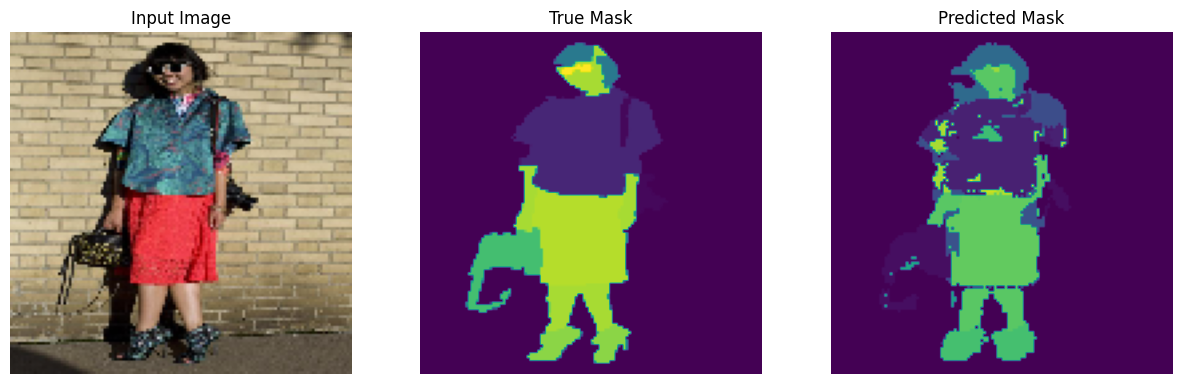


Sample prediction after epoch 7

Epoch 8/10000
201/201 [==============================] - 60s 298ms/step - loss: 0.2763 - accuracy: 0.9262 - val_loss: 0.6849 - val_accuracy: 0.8538


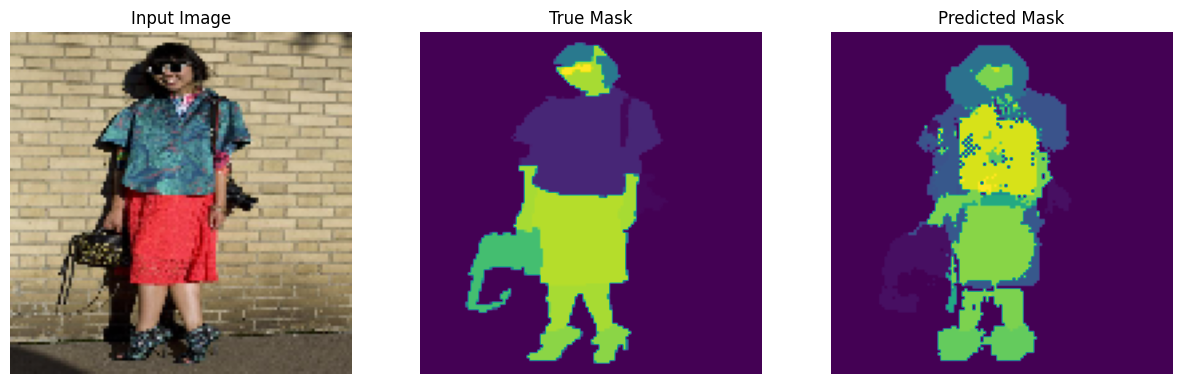


Sample prediction after epoch 8

CPU times: total: 8min 55s
Wall time: 9min 14s


In [24]:
%%time

model_history = model.fit(
    train,
    epochs=10000,
    batch_size=BATCH_SIZE,
    validation_data=test,
    callbacks=[early_stopping, DisplayCallback()]
)
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

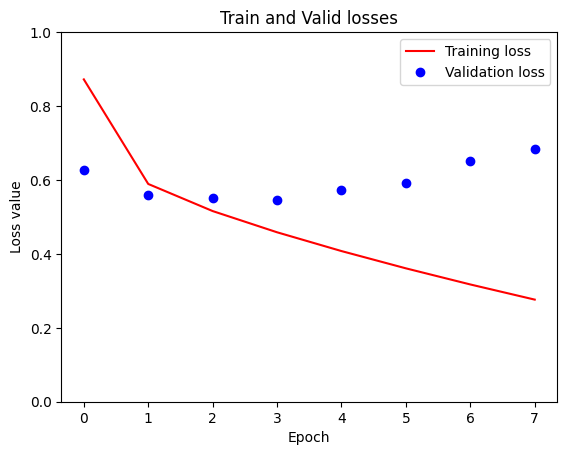

In [25]:
epochs = model_history.epoch

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Train and Valid losses')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.ylim([0,1])
plt.legend()
plt.show()

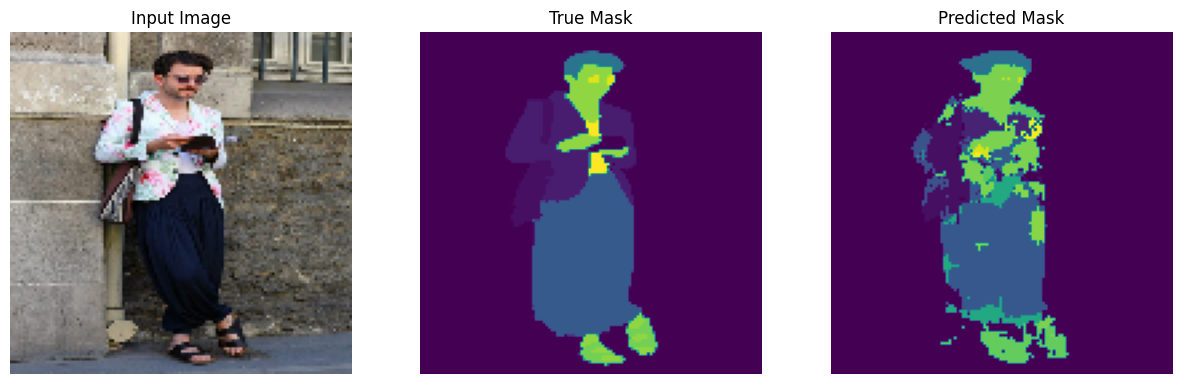

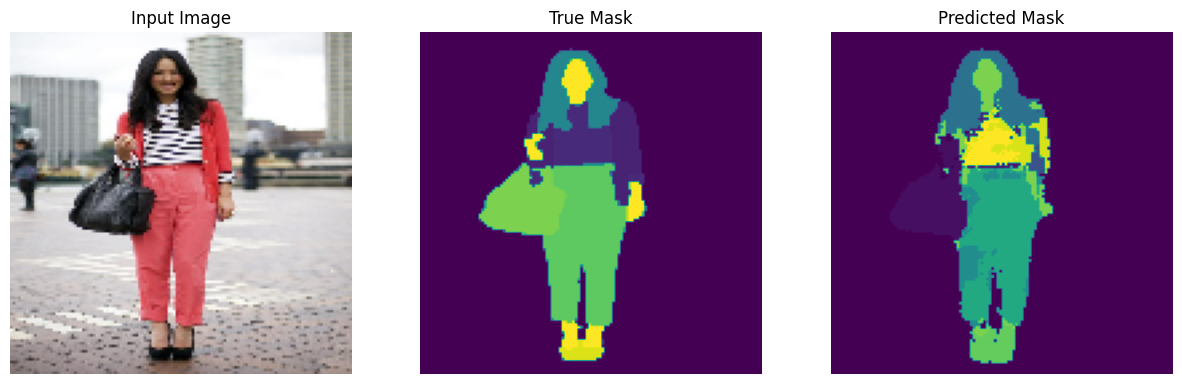

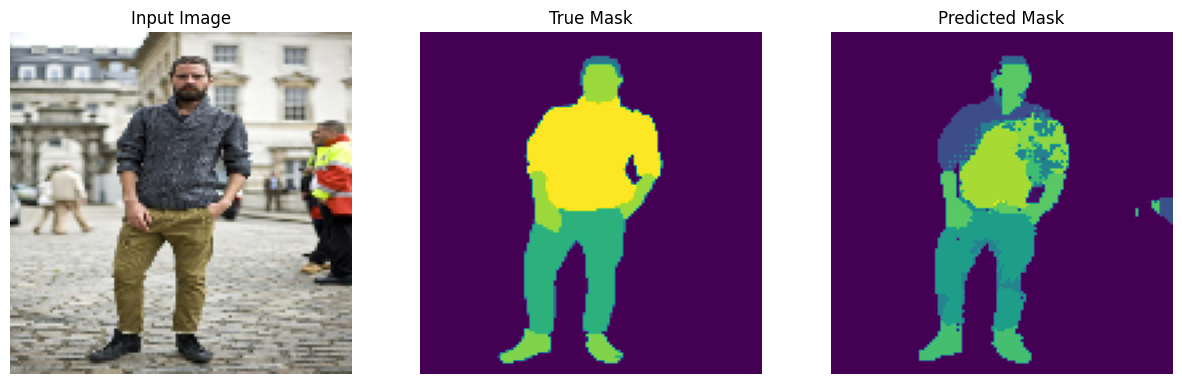

In [26]:
show_predictions(model, test, 3)

Что-то да научилась)

Руками перебирал параметры - до автоподбора не дошел. Но, в принципе-то и так понятно, что можно лучше. Остановлюсь на этом (лучшее accuracy 85.45%)